**#PARCIAL**

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [63]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error


In [6]:

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make','State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [7]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [8]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Punto 0 - exploracion y analisis de datos**

In [36]:
from sklearn.model_selection import cross_val_score
# Cantidad de datos
print(f'Cantidad de datos de entrenamiento: {X_train.shape[0]}')
print('')
#Tipos de datos
print(X_train.dtypes)
print('')
# Comprobación de kilometrajes negativos y outliers
print(f'Cantidad de kilometrajes negativos: {X_train[X_train["Mileage"]<0].shape[0]}')
print('')
# Búsqueda de valores nulos en el dataset
print(data.isnull().sum().sort_values(ascending=False).head(10))

Cantidad de datos de entrenamiento: 7031

Year           int64
Mileage        int64
M_Camry         bool
M_Camry4dr      bool
M_CamryBase     bool
M_CamryL        bool
M_CamryLE       bool
M_CamrySE       bool
M_CamryXLE      bool
dtype: object

Cantidad de kilometrajes negativos: 0

Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de REGRESIÓN
clf = RandomForestRegressor()
clf

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
#Impresión de desempeño del modelo usando la función cross_val_score
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.801793
std       0.011003
min       0.782063
25%       0.796912
50%       0.803259
75%       0.806428
max       0.817185
dtype: float64

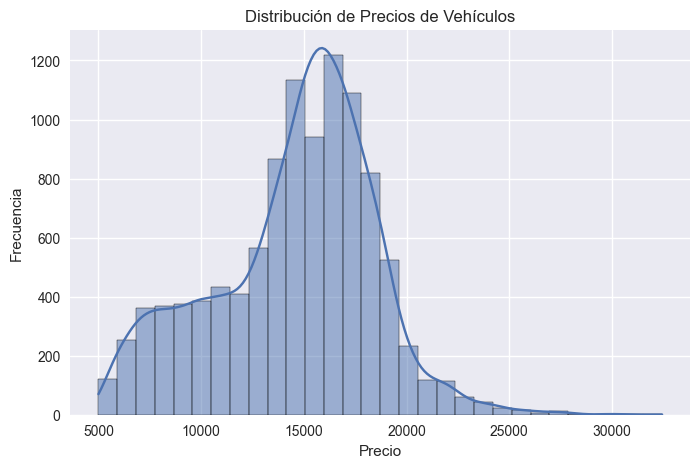

In [27]:

# Ver la distribución de la variable objetivo 'Price'
plt.figure(figsize=(8,5))
sns.histplot(data['Price'], bins=30, kde=True)
plt.title('Distribución de Precios de Vehículos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

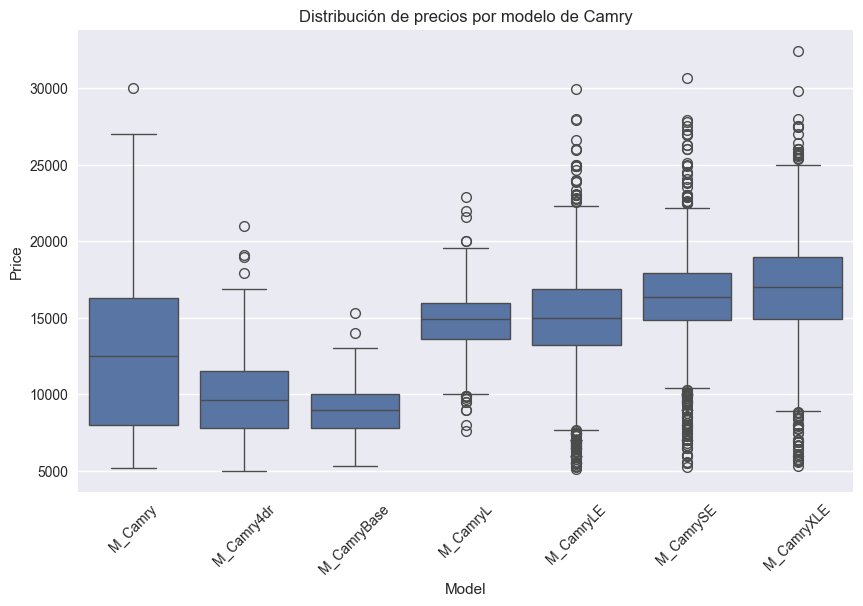

In [32]:
# Primero seleccionemos las columnas de modelo
model_cols = [col for col in data.columns if col.startswith('M_')]

# Creamos un DataFrame con los modelos y el precio
model_data = pd.concat([data[model_cols], data['Price']], axis=1)

# Convertimos las columnas dummies en una sola columna categórica
model_data = model_data.melt(id_vars='Price', var_name='Model', value_name='Flag')
model_data = model_data[model_data['Flag'] == 1]

plt.figure(figsize=(10,6))
sns.boxplot(x='Model', y='Price', data=model_data)
plt.xticks(rotation=45)
plt.title('Distribución de precios por modelo de Camry')
plt.show()

**Punto 1 - Random forest con librería**

In [40]:
y_pred = clf.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Squared Error: 439311.4341927822
R^2 Score: 0.9712795994307097
Mean Absolute Error: 489.89859553620727
Mean Absolute Percentage Error: 3.555374279495491%


**Punto 2 - Calibración de parámetros Random forest**

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de listas para almacenar los resultados
r2_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    r2_scores.append(cross_val_score(clf, X, y, cv=5, scoring='r2').mean())



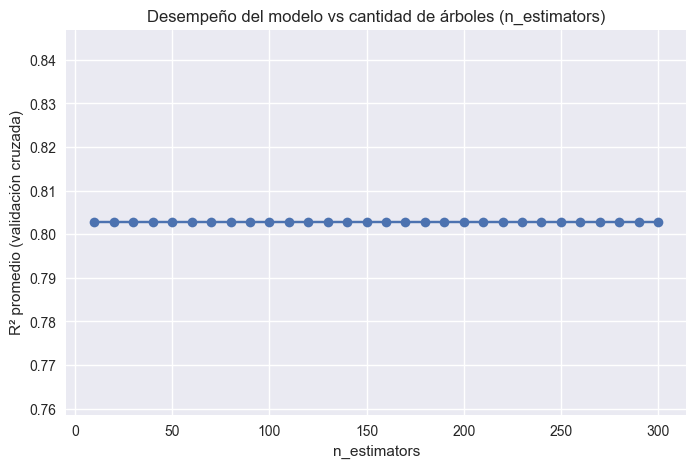

In [44]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.figure(figsize=(8,5))
plt.plot(estimator_range, r2_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('R² promedio (validación cruzada)')
plt.title('Desempeño del modelo vs cantidad de árboles (n_estimators)')
plt.grid(True)
plt.show()

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X.shape)+1)

# Definición de lista para almacenar la exactitud (rd_scores) promedio para cada valor de max_features
r2_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=300, max_features=feature, random_state=1, n_jobs=-1)
    r2_scores.append(cross_val_score(clf, X, y, cv=5, scoring='r2').mean())

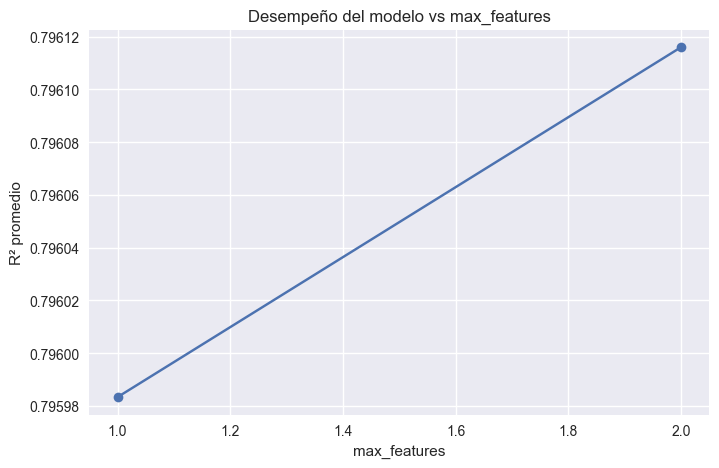

In [49]:
plt.figure(figsize=(8,5))
plt.plot(feature_range, r2_scores, marker='o')
plt.xlabel('max_features')
plt.ylabel('R² promedio')
plt.title('Desempeño del modelo vs max_features')
plt.grid(True)
plt.show()

In [58]:
# Crear la lista  de valores para iterar sobre diferentes valores de max_depth
depth_range = range(2, 31)
# Definición de lista para almacenar la exactitud (rd_scores) promedio para cada valor de max_depth
r2_scores = []
# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range: 
    clf = RandomForestRegressor(n_estimators=300, max_depth=depth, random_state=1, n_jobs=-1)
    r2 = cross_val_score(clf, X, y, cv=5, scoring='r2').mean()
    r2_scores.append(r2)

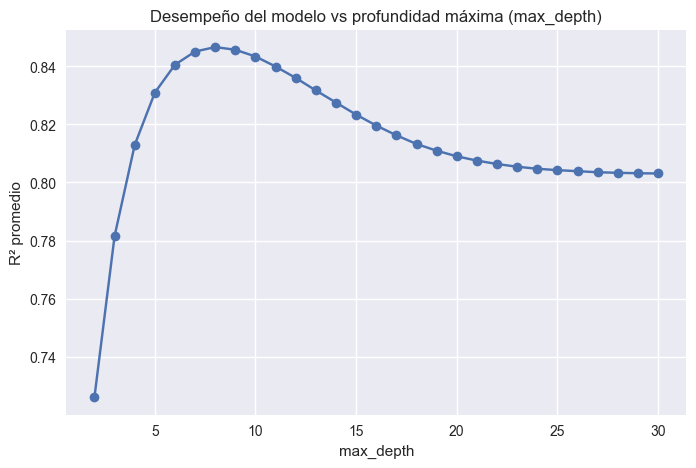

In [59]:
plt.figure(figsize=(8,5))
plt.plot(depth_range, r2_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('R² promedio')
plt.title('Desempeño del modelo vs profundidad máxima (max_depth)')
plt.grid(True)
plt.show()

In [ ]:
#Encontrar los mejores hiperparametros:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'max_features': [4, 6, 8]
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=1),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid.fit(X, y)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor desempeño (R²):", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 10, 'max_features': 4, 'n_estimators': 300}
Mejor desempeño (R²): 0.8461823923655454


In [65]:
#Entrenar el modelo con los mejores hiperparámetros encontrados:
best_clf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    max_features=4
)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
print("R² test:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R² test: 0.839329329842047
MAE: 1150.6075599201106
RMSE: 1567.6868292374695


<Axes: xlabel='Importance', ylabel='Feature'>

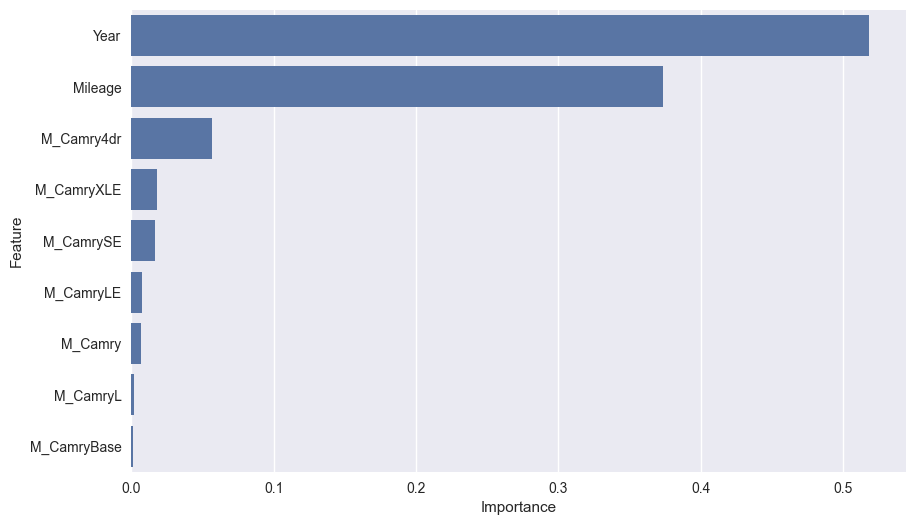

In [69]:
#Importancia de los predictores
importances = best_clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False) 
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)

**Punto 3 - análisis de resultados, gracias y conclusiones**

**#Análisis de resultados**

**1. Mejores hiperparámetros:**

max_depth = 10, max_features = 4, n_estimators = 300

**2. Mejor desempeño (R^2): 0.846**

**RMSE**:

Promedio de error para calcular la venta del auto, en estga ocacion toma en medida de error 1567 dolares para optener el valor el auto

**MAE**:

Mide los errores medio, pero no es penalizado por los valores grandes
